In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_auc_score, roc_curve, accuracy_score)
import shap
import joblib

In [ ]:
#Load the dataset
df = pd.read_csv('blood.csv')
print("Rows, Columns:", df.shape)
df.head()

Rows, Columns: (748, 5)


,Recency,Frequency,Monetary,Time,Class
0,2,50,12500,99,1
1,0,13,3250,28,1
2,1,17,4000,36,1
3,2,20,5000,45,1
4,1,24,6000,77,0


In [ ]:
#Quick exploration
print("Columns and types:")
print(df.dtypes)
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nBasic stats for numeric columns:")
display(df.describe().T)

Columns and types:
Recency      int64
Frequency    int64
Monetary     int64
Time         int64
Class        int64
dtype: object

Missing values per column:
Recency      0
Frequency    0
Monetary     0
Time         0
Class        0
dtype: int64

Basic stats for numeric columns:


,count,mean,std,min,25%,50%,75%,max
Recency,748.0,9.506684,8.095396,0.0,2.75,7.0,14.0,74.0
Frequency,748.0,5.516043,5.841825,1.0,2.00,4.0,7.0,50.0
Monetary,748.0,1378.676471,1459.826781,250.0,500.00,1000.0,1750.0,12500.0
Time,748.0,34.284759,24.380307,2.0,16.00,28.0,50.0,99.0
Class,748.0,0.237968,0.426124,0.0,0.00,0.0,0.0,1.0


In [25]:
if 'recommendation' in df.columns:
    target_col = 'recommendation'
elif 'disease' in df.columns:
    target_col = 'disease'
elif 'diabetes' in df.columns:
    target_col = 'diabetes'
else:
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    # heuristics — adapt to dataset columns
    risk = pd.Series(0, index=df.index)
    if 'cholesterol' in df.columns:
        risk = risk | (df['cholesterol'] > 240)
    if 'blood_glucose' in df.columns:
        risk = risk | (df['blood_glucose'] > 126)
    for c in ['systolic_bp','blood_pressure','bp_sys']:
        if c in df.columns:
            risk = risk | (df[c] > 140)
    df['risk_label'] = risk.astype(int)
    target_col = 'risk_label'
    print("Created synthetic target 'risk_label' - please adapt if you have a real label.")

Created synthetic target 'risk_label' - please adapt if you have a real label.


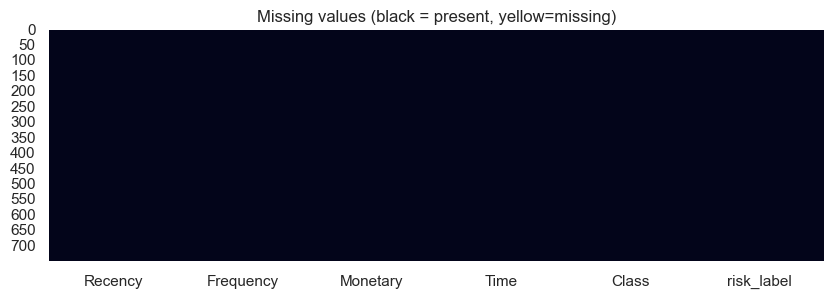

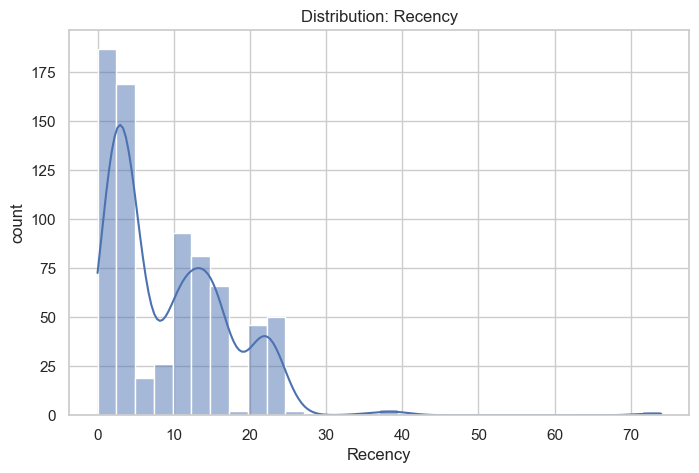

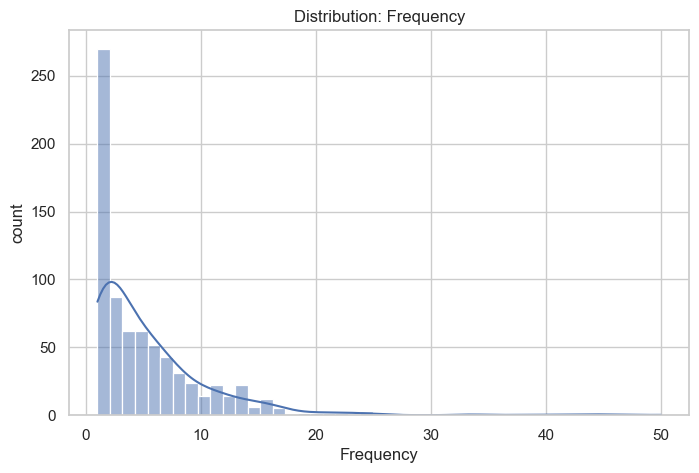

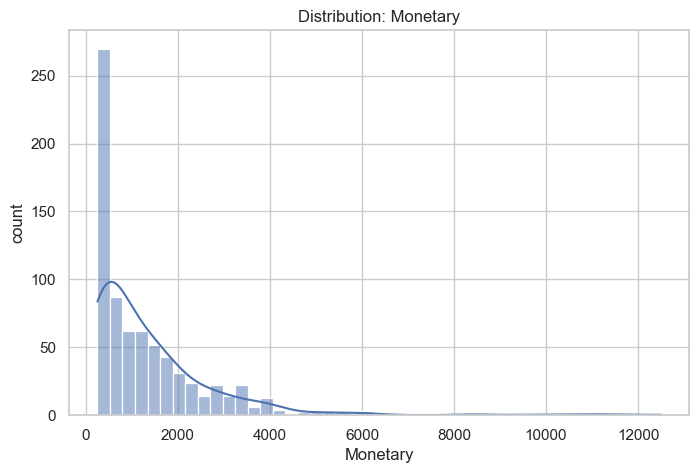

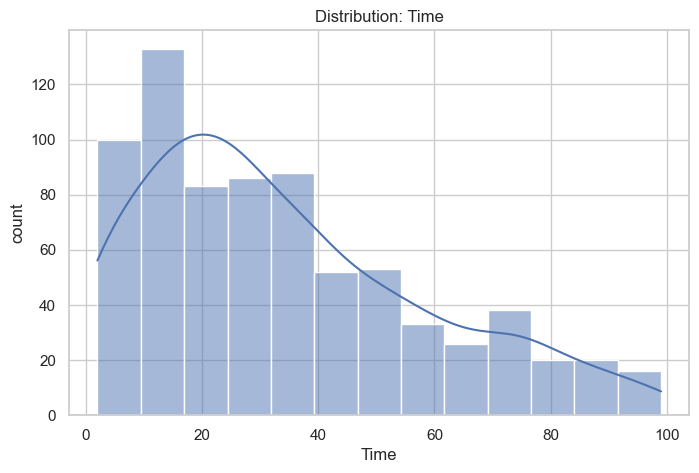

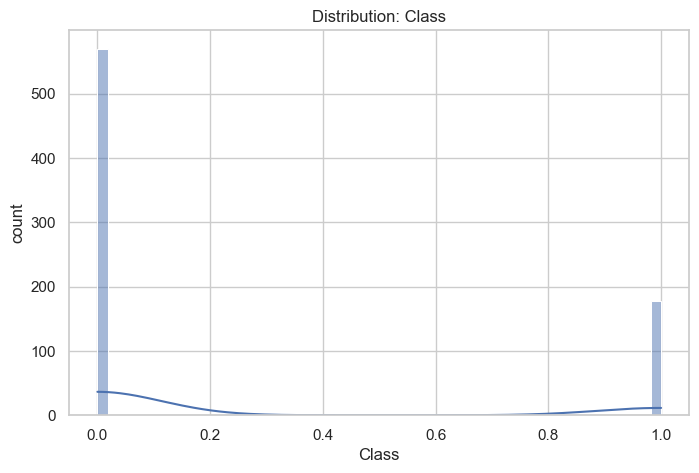

In [26]:
#EDA
#Missing value heatmap
plt.figure(figsize=(10,3))
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing values (black = present, yellow=missing)")
plt.show()

#Numeric distributions for top numeric columns
num_cols = df.select_dtypes(include=np.number).columns.tolist()
num_cols = [c for c in num_cols if c != target_col][:6]  # show up to 6
for c in num_cols:
    plt.figure()
    sns.histplot(df[c].dropna(), kde=True)
    plt.title(f"Distribution: {c}")
    plt.xlabel(c)
    plt.ylabel("count")
    plt.show()

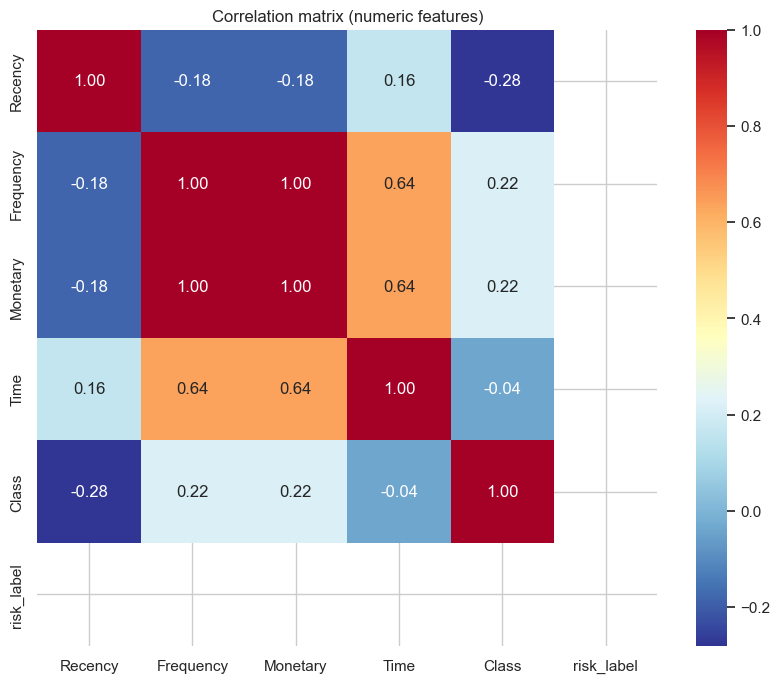

In [27]:
#Correlation heatmap
corr = df.select_dtypes(include=np.number).corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdYlBu_r", square=False)
plt.title("Correlation matrix (numeric features)")
plt.show()

In [ ]:
#Preprocessing pipeline
feature_cols = [c for c in df.columns if c != target_col]

numeric_features = df[feature_cols].select_dtypes(include=np.number).columns.tolist()
categorical_features = [c for c in feature_cols if c not in numeric_features]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'  # drop other columns if any
)

In [55]:
#Train/test split
X = df[feature_cols]
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train/test sizes:", X_train.shape, X_test.shape)

Train/test sizes: (598, 5) (150, 5)


In [ ]:
#Model training: RandomForest , XGBoost
y_train = y_train.astype(int)
y_test = y_test.astype(int)

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42))
])

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', XGBClassifier(
        objective='binary:logistic', 
        eval_metric='logloss',
        use_label_encoder=False,
        base_score=0.5,
        random_state=42
    ))
])


In [ ]:
# Cross-validate quickly
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("RF CV accuracy:",
      cross_val_score(rf_pipeline, X_train, y_train, cv=cv, scoring='accuracy').mean())

print("XGB CV accuracy:",
      cross_val_score(xgb_pipeline, X_train, y_train, cv=cv, scoring='accuracy').mean())

# Fit best model
best_pipeline = rf_pipeline
best_pipeline.fit(X_train, y_train)

RF CV accuracy: 1.0
XGB CV accuracy: 1.0


,steps,"[('preprocessor', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
#Evaluate on test set
y_pred = best_pipeline.predict(X_test)
y_proba = None
try:
    y_proba = best_pipeline.predict_proba(X_test)[:,1]
except Exception:
    pass

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:")
print(classification_report(y_test, y_pred))

Accuracy: 1.0
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       150

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



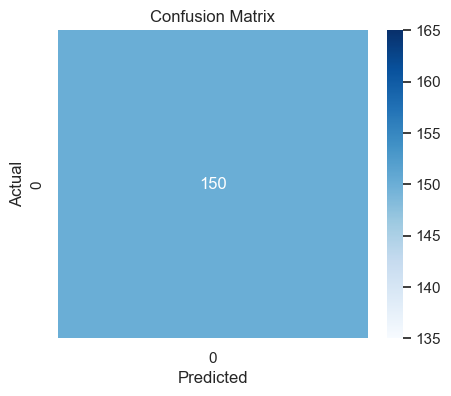

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#ROC Curve
best_pipeline.fit(X_train, y_train)

if hasattr(best_pipeline, "predict_proba") and len(np.unique(y_test)) == 2:
    y_proba = best_pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}", linewidth=2)
    plt.plot([0,1],[0,1],'--', alpha=0.6)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
else:
    if not hasattr(best_pipeline, "predict_proba"):
        print("Model does not support probability predictions.")
    else:
        print("Cannot plot ROC — y_test does not contain both classes:", np.unique(y_test))

Cannot plot ROC — y_test does not contain both classes: [0]


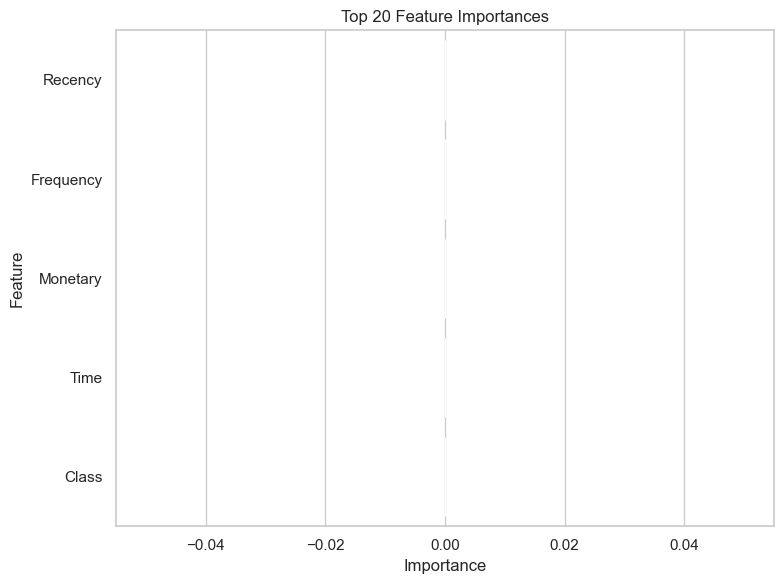

In [ ]:
#Feature importance
pre = best_pipeline.named_steps['preprocessor']

num_feats = numeric_features

cat_feats = []
if categorical_features:
    ohe = pre.named_transformers_['cat'].named_steps['onehot']
    cat_names = ohe.get_feature_names_out(categorical_features)
    cat_feats = list(cat_names)
all_feats = num_feats + cat_feats

clf = best_pipeline.named_steps['clf']
importances = clf.feature_importances_
feat_imp = pd.Series(importances, index=all_feats).sort_values(ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


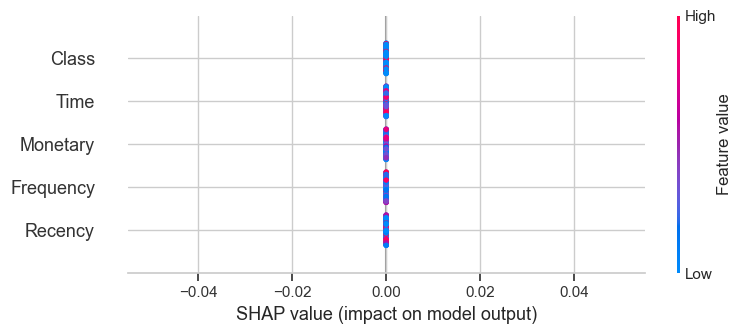

In [ ]:
#SHAP explanations
explainer = shap.Explainer(clf, pre.transform(X_train).astype(float))

X_shap = pre.transform(X_test).astype(float)
shap_values = explainer(X_shap[:200])

shap.summary_plot(shap_values, features=X_shap[:200], feature_names=all_feats, show=True)

In [ ]:
#Recommendation generator
def generate_recommendation(single_row_df):
    """
    Input: single row pandas DataFrame with the same columns as original X
    Output: human readable recommendation
    """
    pred = best_pipeline.predict(single_row_df)[0]
    
    mapping = {
        0: "Low risk: Maintain current healthy habits; annual checkup recommended.",
        1: "Elevated risk: Schedule a doctor visit for assessment; consider lifestyle changes (diet/exercise)."
    }
    
    return mapping.get(pred, f"Predicted label {pred}. Consult clinician for personalized plan.")

example = X_test.iloc[[0]]
print(generate_recommendation(example))


Low risk: Maintain current healthy habits; annual checkup recommended.
